# Interludium - typy w Pythonie
Typowanie jest w rzeczywistości nakładaniem ograniczeń na zbiory wartości zmiennych w programach, co ułatwia wnioskowanie o nich, w szczególności w sposób automatyczny. Istnieją różne podejścia do tego problemu i różne sposoby jego kategoryzacji - jednym z nich jest to kiedy typowanie się odbywa. Ze względu na tą cechę, języki mogą być statycznie lub dynamicznie typowane.

Statyczne typy są sprawdzane przed wykonaniem, co ułatwia konstruowanie narzędzi weryfikujących poprawność programów przed ich rzeczywistym wykonaniem. Historycznie patrząc, języki statycznie typowane były nieco trudniejsze do pisania dla programistów - np.: zmienne nie mogły zmieniać swojego typu w trakcie wykonania, ale narzędzia diagnozujące problemy przed wykonaniem były nieco bardziej zaawansowane, podobnie jak optymalizacje, których mógł dokonać kompilator, w rezultacie produkując szybszy kod.

Amerykańska korporacja AirBnB przeprowadziła analizę postmortem, z której wynikało, że 38% bugów mogłoby być unikniętych, jeśli postawiono by na język typowany statycznie (w ich przypadku porównanie dotyczyło JavaScript vs TypeScript):

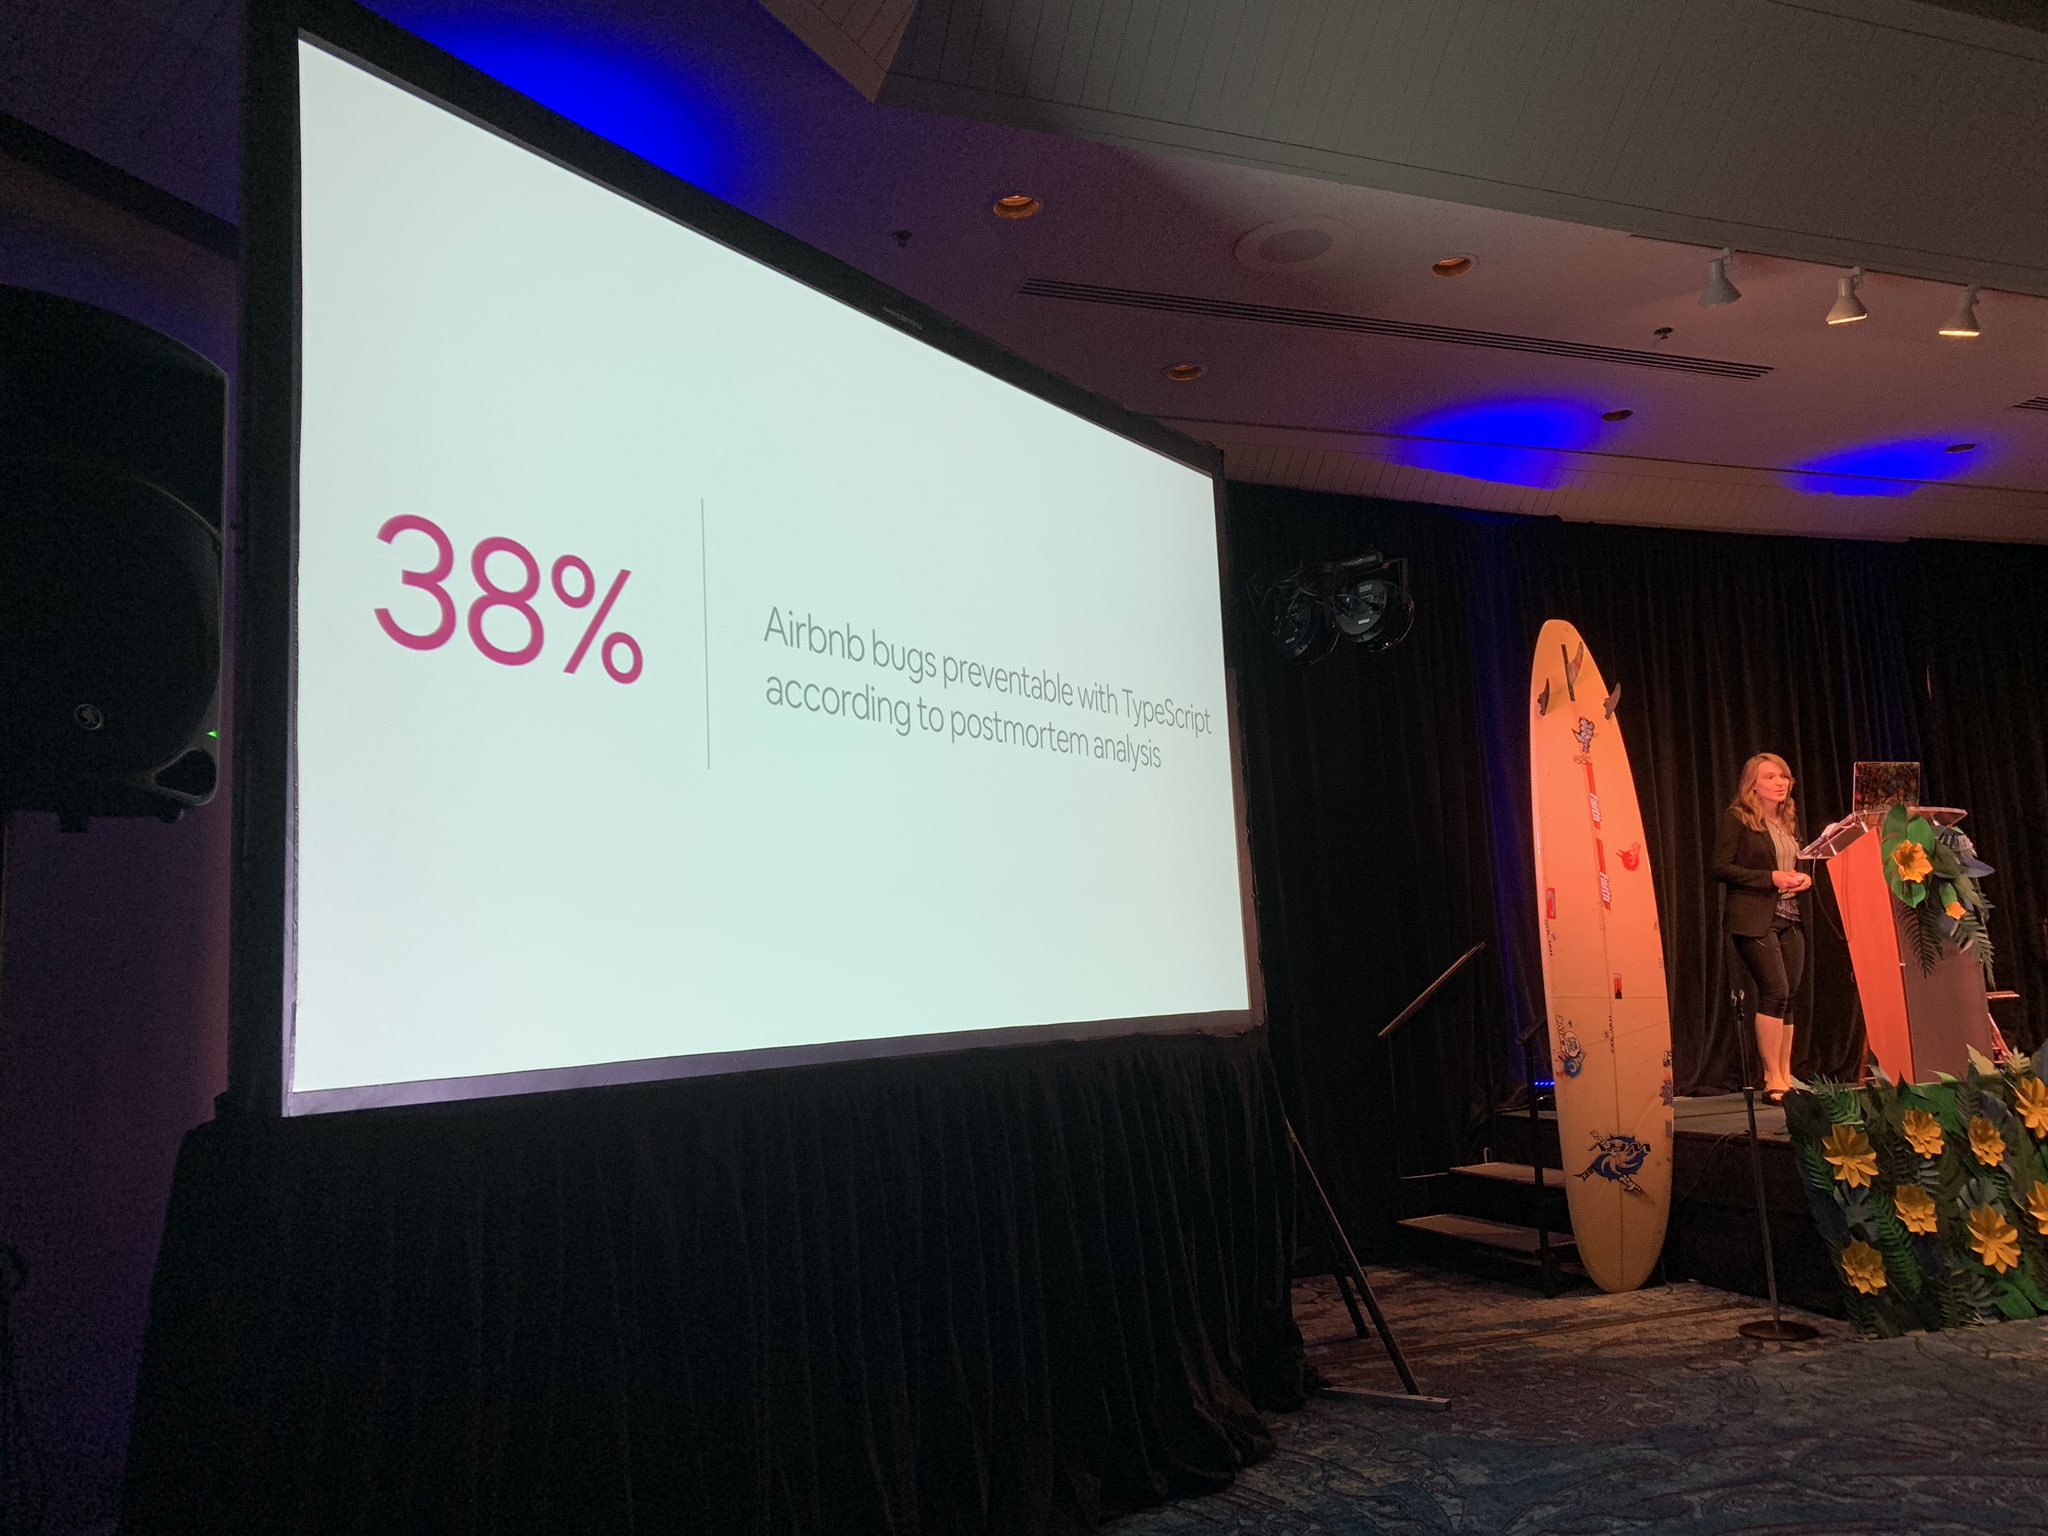

W Pythonie oryginalnie postawiono na typowanie dynamiczne - interpreter kalkuluje i sprawdza typy w czasie wykonania, a zmienne mogą swobodnie zmieniać swoje typy w trakcie działania programu. Kod, który nigdy nie będzie wykonany, nie jest typowany:

In [ ]:
if False:
    1 + "Hello"
print("world")

In [ ]:
1 + "Hello"

In [ ]:
2 * "Hello"

In [ ]:
test = "test"
print(type(test))
test = 5
print(type(test))

Wraz z rozwojem języka, Python stał się językiem o opcjonalnym typowaniu statycznym (*ang: gradually typed* - przy użyciu anotacji typów) i pojawiły się narzędzia wymuszające statyczne typowanie - np.: `mypy`. Mimo to, zdecydowana większość kodu Pythonowego nadal jest dynamicznie typowana, a język nie wymusza stosowania anotacji typowych, choć należy podkreślić benefity ich stosowania, jak np.: wykrywanie wielu bugów przy użyciu narzędzi statycznej analizy kodu.

### Deklarowanie typów

#### Funkcje
```
def func(arg: arg_type, optarg: arg_type = default) -> return_type:
    ...
    
def func2(x: str) -> Optional[str]:
    if x != "":
        return "cokolwiek" + x
    else:
        return None
```

#### Zmienne
```
cośtam: str
jakaś_liczba: int
cards: list[Card]
results: dict[tuple[int, int, int], str]

from typing import Union
lst: list[Union[int, str, bool, Card]]
```

### Mypy
Aby użyć `mypy` wystarczy, że najpierw zainstalujemy go przez `pip`:
```
pip install mypy
```

... a potem odpalimy przy użyciu:
```
mypy --check-untyped-defs my_script.py
```
Flaga `--check-untyped-defs` włącza sprawdzanie typów w ciele nieotypowanych funkcji - domyślnie sprawdzany jest tylko scope globalny. Można również wymusić sprawdzanie czy wszystkie funkcje są otypowane - przy użyciu `--disallow-untyped-defs`.

Przykładowo dla takiego wejścia:

```
def multiply_by_2(number: float) -> float:
    return 2 * number


multiply_by_2("I'm not a float")
```

dostaniemy:
```
>>> mypy float_check.py
float_check.py:5: error: Argument 1 to "multiply_by_2" has incompatible
                        type "str"; expected "float"
Found 1 error in 1 file (checked 1 source file)
```
Przydatne do debugowania błędów znalezionych przez `mypy` bywa użycie dwóch funkcji: `reveal_type` oraz `reveal_locals`. Są one zdefiniowane przez `mypy`, jednak nie importuje się ich do swojego kodu. Zamiast tego można je dodać w miejscu gdzie ma się wątpliwości co do typu wyliczanego przez `mypy`, uruchomić `mypy` a następnie usunąć - Python rzuci błędem dot. nieznanych nazw!

```
import math
reveal_type(math.e)

radius = 1
area = math.pi * radius * radius
reveal_locals()
```

```
>>> mypy reveal.py
reveal.py:4: error: Revealed type is 'builtins.float'

reveal.py:8: error: Revealed local types are:
reveal.py:8: error: area: builtins.float
reveal.py:8: error: radius: builtins.int
```
Oczywiście, `mypy` ma dużo innych opcji i konfiguracji - ich opis można znaleźć [tu](https://mypy.readthedocs.io/en/stable/).

### Kiedy w ogóle przejmować się typami

1. Kiedy ma się małe doświadczenie z Pythonem, to zdecydowanie **nie jest konieczne** - może pomóc, ale są istotniejsze mechanizmy języka
2. W drobnych, podręcznych skryptach, które nie będą obiektem zainteresowań reszty zespołu w firmie - **raczej nie warto**. W niczym nie przeszkadzają, IDE/edytor może lepiej podpowiadać, ale nie ma to wielkiego znaczenia
3. **Zdecydowanie warto** w bibliotekach używanych przez innych, zwłaszcza w tych, którymi dzielicie się przez PyPI (lub lokalną jego instalację). Wówczas użytkownicy mogą zdecydowanie łatwiej poznawać waszą bibliotekę z pomocę ich IDE, bez konieczności zgadywania waszych intencji i supresowania błędów typów podkreślanych przez ich edytor
4. **Zdecydowanie warto** w jakkolwiek większych projektach, gdzie jeden lub więcej zespołów kolaborują nad kodem przez dłuższy okres czasu - wówczas dużo łatwiej zrozumieć założenia architektoniczne oryginalnych autorów, używać innych modułów i znajdować subtelne bugi.


Gdy chcemy się zajmować typami w Pythonie i używać ich to ulepszania struktury naszej aplikacji, istnieje kilka mechanizmów, które pozwalają nam w elastyczny sposób z nimi pracować, nieco podobnie do języków statycznie typowanych: `dataclasses`, `ABC` i `Protocols`.

## Dataclass
Często klasy są jedynie kontenerami na dane, bez rozbudowanych zachowań zmieniających ich wewnętrzny stan zgodnie z pewną logiką. Obiekty tych klas powinny umożliwiać łatwe tworzenie, porównywanie, wypisywanie w czytelny sposób swojej zawartości. Począwszy od Pythona 3.7 mamy do dyspozycji bibliotekę `dataclasses`, która upraszcza tworzenie i używanie takich klas - zamiast:

In [ ]:
class Card:
    def __init__(self, rank, suite):
        self.rank = rank
        self.suite = suite
    
    def __eq__(self, other):
        return isinstance(other, Card) and self.rank == other.rank and self.suite == other.suite
    
    def __repr__(self):
        return f"Card({self.rank} {self.suite})"

queen_of_hearts = Card('Q', '♡')
another_queen_of_hearts = Card('Q', '♡')
assert queen_of_hearts == another_queen_of_hearts

... możemy zrobić jedynie tyle:

In [ ]:
from dataclasses import dataclass

@dataclass
class Card:
    rank: str
    suite: str


queen_of_hearts = Card('Q', '♡')
another_queen_of_hearts = Card('Q', '♡')
assert queen_of_hearts == another_queen_of_hearts

Jak widać, `dataclasses` oszczędza nam sporo pisania - wystarczy, że odpowiednie pola zostaną zadeklarowane wraz ze swoim typem (konieczne! Ale może być to `Any`), a resztę zrobi za nas biblioteka. Przydatne bywa też uczynienie naszej klasy niezmienialną (*ang. mutable*) - nic prostszego! `dataclasses` czyni to naprawdę prostym:

In [ ]:
from dataclasses import dataclass

@dataclass
class Card:
    rank: str
    suite: str

queen_of_hearts = Card('Q', '♡')
queen_of_hearts.rank = 'K'


@dataclass(frozen=True)
class ImmutableCard:
    rank: str
    suite: str

immutable_queen_of_hearts = ImmutableCard('Q', '♡')
immutable_queen_of_hearts.rank = 'K'

Oczywiście, pola takich klas mogą mieć wartości domyślne:

In [ ]:
from dataclasses import dataclass
@dataclass
class Card:
    rank: str = get_rank()
    suite: str = '♣'

Card()

Nie należy jednak bezpośrednio wyliczać ich wywołaniem funkcji! Jest to częsty błąd w Pythonie, polegający na użyciu mutowalnych argumentów domyślnych - logika wewnątrz `dataclasses` pod spodem wygeneruje normalną klasę, zawierającą np. konstruktor (`__init__`), który dostanie podane tu wartości jako parametry. Jeśli chcemy dynamicznie lub leniwie produkować wartości domyślne możemy to zrobić tak:

In [ ]:
from dataclasses import dataclass, field
import random

RANKS = '2 3 4 5 6 7 8 9 10 J Q K A'.split()
SUITS = '♣ ♢ ♡ ♠'.split()

@dataclass
class Card:
    rank: str = field(default_factory=lambda: random.choice(RANKS))
    suite: str = '♣'

Card()

`field` może zmieniać różne inne parametry pola - domyślną wartość (stałą), sposób reprezentacji, porównywania, liczenia hashu etc.

#### UWAGA:

In [ ]:
# tu parametr domyślny jest wyliczany tylko raz!!!
def fun1(x, lst = []):
    lst.append(x)
    return lst


print(fun1(5))
print(fun1(6))

# fix
def fun2(x, lst = None):
    if not lst:
        lst = []
    lst.append(x)
    return lst

print(fun2(5))
print(fun2(6))

## ABC
Abstrakcyjne klasy bazowe to klasy, które istnieją po to by być rozszerzanymi przez dziedziczenie. Definiują one abstrakcyjny interfejs, który służy za swojego rodzaju kontrakt na którym może polegać reszta kodu. Abstrakcyjne klasy bazowe nie mają w założeniu ich twórców kiedykolwiek służyć do tworzenia obiektów - część ich metod może nie być zaimplementowana! Teoretycznie nic nie stoi na przeszkodzie bo owe klasy tworzyć tak:

In [ ]:
# abstrakcyjna klasa bazowa
class UserRepository:
    def fetch(id):
        raise NotImplementedError
    
    def store(user):
        raise NotImplementedError

# rzeczywista implementacja
class SQLiteUserRepository(UserRepository):
    def __init__(self, path):
        with open(path) as db:
            self.db = connect(db)
            ... # tu jakieś otwarcie bazy
        
    def fetch(id):
        row = self.db.execute(f"SELECT * FROM auth_user WHERE id = {sanitize(id)}")
        ... # tu jakaś dalsza część logiki
    
    def store(user):
        self.db.execute(f"INSERT INTO ...")

... jednak nie mamy żadnej gwarancji, że ktoś nie spróbuję stworzyć egzemplarza naszej abstrakcyjnej klasy bazowej. Z pomocą przychodzi moduł `abc` biblioteki standardowej:

In [ ]:
from abc import ABC, abstractmethod

class UserRepository(ABC):
    @abstractmethod
    def fetch(id):
        ...
    
    @abstractmethod
    def store(user):
        ...

repo = UserRepository()

Abstrakcyjne klasy bazowe w Pythonie mają znaczenie głównie w większych bazach kodu, gdzie nawigowanie grafu współpracujących obiektów jest dość trudne i przydaje się mechanizm opisujący na jakich abstrakcjach polegamy. Takie do tego podejście jest przykładem tzw. nominalnego podejścia do typowania - klasa jest uznawana za spełniającą określony interfejs wtedy, gdy eksplicite odziedziczy po klasie abstrakcyjnej (lub jej podklasie) mającej taki interfejs.

Implementowanie wielu klas abstrakcyjnych, zwłaszcza, gdy ich interfejsy nie mają wspólnego przecięcia, jest również jednym z sensownych zastosowań wielodziedziczenia.

## Protocol - [PEP-544](https://www.python.org/dev/peps/pep-0544/)
Z punktu widzenia statycznego typowania Pythona, nominalne typowanie - np.: przy użyciu `abc.ABC` pozwala na określenie naszych oczekiwań względem konkretnej implementacji interfejsu na którym chcemy polegać. Wtedy wiemy, że możemy bezpiecznie wywoływać metody lub odczytywać property przekazanego nam obiektu (oczywiście, jeśli uruchomimy analizator statyczny - np.: `mypy`), bez narażania się na błędy podczas wykonania kodu na produkcji.

To podejście zaczyna jednak być bardzo uciążliwe, gdy mamy wiele współpracujących pakietów - łatwo wówczas np.: o cykle w importach. Dodatkowo, ten model myślenia o typach jest dość nieelastyczny i wymaga przestawienia myślenia na inne niż w przypadku dynamicznego typowania, w przypadku, gdy jesteśmy przyzwyczajeni do zapominania o typach w Pythonie. Duck-typing, z którego jest znany Python i który w rzeczywistości działa podczas wykonania kodu polega na obserwacji, że "jeśli coś kwacze jak kaczka, chodzi jak kaczka to jest kaczką". Inaczej mówiąc interesuje nas to, że dany obiekt ma określone zachowania i dane, nie zaś szczegóły tego, jak został zaimplementowany i czy jego twórca w ogóle wiedział o naszym przypadku użycia.

W związku z tym problemem PEP-544 wprowadził do świata Pythona koncept `Protocols`, który umożliwia spełnianie relacji bycia podtypem, przez klasy, które nie definiują explicite, że dziedziczą po danym interfejsie, ale implementują jego metody i wymagane property:

In [ ]:
from typing import Protocol

# Protokół
class SupportsClose(Protocol):
    def close(self) -> None:
        ...

# Przykładowa implementacja - nie musi dziedziczyć po SupportsClose
class Resource:
    def __init__(self, f):
        self.file = f

    def close(self) -> None:
        self.file.close()

# ...ale może
class Connection(SupportsClose):
    def close():
        print("closing connection")
        ...

# Przykład użycia w sygnaturze typu
def close_all(things: Iterable[SupportsClose]) -> None:
    for t in things:
        t.close()

f = open('foo.txt')
r = Resource(open("bar.txt"))
close_all([f, r])  # Oba OK!
close_all([1])     # Error: 'int' has no 'close' method

Protokoły mogą też definiować wymagane pola - jednak muszą być zgodne z [PEP-526](https://www.python.org/dev/peps/pep-0526):

In [ ]:
from typing import Protocol, List

class Template(Protocol):
    name: str        # This is a protocol member
    value: int = 0   # This one too (with default)

    def method(self) -> None:
        self.temp: List[int] = [] # Error in type checker

class Concrete:
    def __init__(self, name: str, value: int) -> None:
        self.name = name
        self.value = value

    def method(self) -> None:
        return

var: Template = Concrete('value', 42)  # OK

Protokoły mogą rozszerzać się przez (wielo-)dziedziczenie, ale nie mogą dziedziczyć po klasach, które nie są protokołami:

In [ ]:
from typing import Sized, Protocol

class SizedAndClosable(Sized, Protocol):
    def close(self) -> None:
        ...

Więcej informacji można znaleźć w [PEP-544](https://www.python.org/dev/peps/pep-0544/#defining-a-protocol).

### *Zadania*

#### *Zadanie 1*
Wykonaj polecenie:
```
git checkout task-3
git checkout -b my-solution-3
```
* [ ] uzupełnij metodę `checkpoint_current_state`
    * [ ] wykorzystaj metodę `save_checkpoints` należącą do `CheckpointStore` i istniejący helper `_hash_dir`
    * [ ] zaimplementuj testy sprawdzające czy metoda `checkpoint_current_state` prawidłowo zapisuje aktualny checkpoint
        * [ ] dla pustych list obserwowanych plików
        * [ ] dla niepustych list obserwowanych plików
        
Zadbaj by w każdym podpunkcie tworzony kod był poprawnie otypowany - możesz zainstalować i uruchomić `mypy` tak, by zobaczyć gdzie są potencjalne problemy.

#### *Zadanie 2* (opcjonalne)
```
git checkout task-4
git checkout -b my-solution-4
```
* [ ] uzupełnij metodę `get_changes_since_last_checkpoint`
    * [ ] zdefiniuj przypadki testowe na podstawie specyfikacji zapisanej w docstringu
    * [ ] napisz odpowiednie testy
    * [ ] napisz implementacje, tak by przechodziła testy
        * [ ] bonus: spraw by wyjątek NoPriorCheckpointError jednoznacznie wskazywał na oryginalny FileNotFoundError jako swoją przyczynę
    * [ ] scommituj swoje dokonania na utworzony wcześniej branch